## Information before read
**Tech stack**: Ridge • XGBoost • LightGBM • CatBoost \
**Workflow**: EDA → Cleaning → Feature Engineering → Preprocessing → Modeling → Stacking (Ridge meta on OOF). \
**Goal**: reliable, reproducible RMSE improvement via diverse models and careful validation.

## Imports

In [2]:
#basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import copy
warnings.filterwarnings("ignore")
import time
import json
random_state=42

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#feature engineering
from sklearn.feature_selection import mutual_info_regression

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#algorithms
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
import optuna

#model evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

#stacking
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

#feature selection
from sklearn.feature_selection import RFECV

## First look to data

In [3]:
train = pd.read_csv('data/raw/train.csv', index_col=[0])
test = pd.read_csv('data/raw/test.csv', index_col=[0])
train.head(5)

RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
id                                                              
0      0.603610      -7.636942      0.023500         0.000005   
1      0.639451     -16.267598      0.071520         0.444929   
2      0.514538     -15.953575      0.110715         0.173699   
3      0.734463      -1.357000      0.052965         0.001651   
4      0.532968     -13.056437      0.023500         0.068687   

    InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
id                                                                             
0            0.000001                   0.051385   0.409866      290715.6450   
1            0.349414                   0.170522   0.651010      164519.5174   
2            0.453814                   0.029576   0.423865      174495.5667   
3            0.159717                   0.086366   0.278745      225567.4651   
4            0.000001                   0.331345   0.477769      213960.6789   

      Energy  BeatsPerMinute  
id                            
0   0.826267       147.53020  
1   0.145400       136.15963  
2   0.624667        55.31989  
3   0.487467       147.91212  
4   0.947333        89.58511

In [4]:
#reserved for pipieline
pipe_train = train.copy()
pipe_test = test.copy()

#for data analysis
train_df = train.copy()
test_df = test.copy()
train_df.head(5)

RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
id                                                              
0      0.603610      -7.636942      0.023500         0.000005   
1      0.639451     -16.267598      0.071520         0.444929   
2      0.514538     -15.953575      0.110715         0.173699   
3      0.734463      -1.357000      0.052965         0.001651   
4      0.532968     -13.056437      0.023500         0.068687   

    InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
id                                                                             
0            0.000001                   0.051385   0.409866      290715.6450   
1            0.349414                   0.170522   0.651010      164519.5174   
2            0.453814                   0.029576   0.423865      174495.5667   
3            0.159717                   0.086366   0.278745      225567.4651   
4            0.000001                   0.331345   0.477769      213960.6789   

      Energy  BeatsPerMinute  
id                            
0   0.826267       147.53020  
1   0.145400       136.15963  
2   0.624667        55.31989  
3   0.487467       147.91212  
4   0.947333        89.58511

## Explore data analysis

In [5]:
train_df.describe().T

count           mean           std  \
RhythmScore                524164.0       0.632843      0.156899   
AudioLoudness              524164.0      -8.379014      4.616221   
VocalContent               524164.0       0.074443      0.049939   
AcousticQuality            524164.0       0.262913      0.223120   
InstrumentalScore          524164.0       0.117690      0.131845   
LivePerformanceLikelihood  524164.0       0.178398      0.118186   
MoodScore                  524164.0       0.555843      0.225480   
TrackDurationMs            524164.0  241903.692949  59326.601501   
Energy                     524164.0       0.500923      0.289952   
BeatsPerMinute             524164.0     119.034899     26.468077   

                                    min            25%            50%  \
RhythmScore                    0.076900       0.515850       0.634686   
AudioLoudness                -27.509725     -11.551933      -8.252499   
VocalContent                   0.023500       0.023500       0.066425   
AcousticQuality                0.000005       0.069413       0.242502   
InstrumentalScore              0.000001       0.000001       0.074247   
LivePerformanceLikelihood      0.024300       0.077637       0.166327   
MoodScore                      0.025600       0.403921       0.564817   
TrackDurationMs            63973.000000  207099.876625  243684.058150   
Energy                         0.000067       0.254933       0.511800   
BeatsPerMinute                46.718000     101.070410     118.747660   

                                     75%            max  
RhythmScore                     0.739179       0.975000  
AudioLoudness                  -4.912298      -1.357000  
VocalContent                    0.107343       0.256401  
AcousticQuality                 0.396957       0.995000  
InstrumentalScore               0.204065       0.869258  
LivePerformanceLikelihood       0.268946       0.599924  
MoodScore                       0.716633       0.978000  
TrackDurationMs            281851.658500  464723.228100  
Energy                          0.746000       1.000000  
BeatsPerMinute                136.686590     206.037000

**Grouping features for preprocessing purpose**

In [6]:
numerical_features = [feature for feature in train_df.columns if feature!='BeatsPerMinute']
target = "BeatsPerMinute"

### Sampling data for eda

In [7]:
sampled_train = train_df.sample(frac = 0.01)

### Features distrtibution

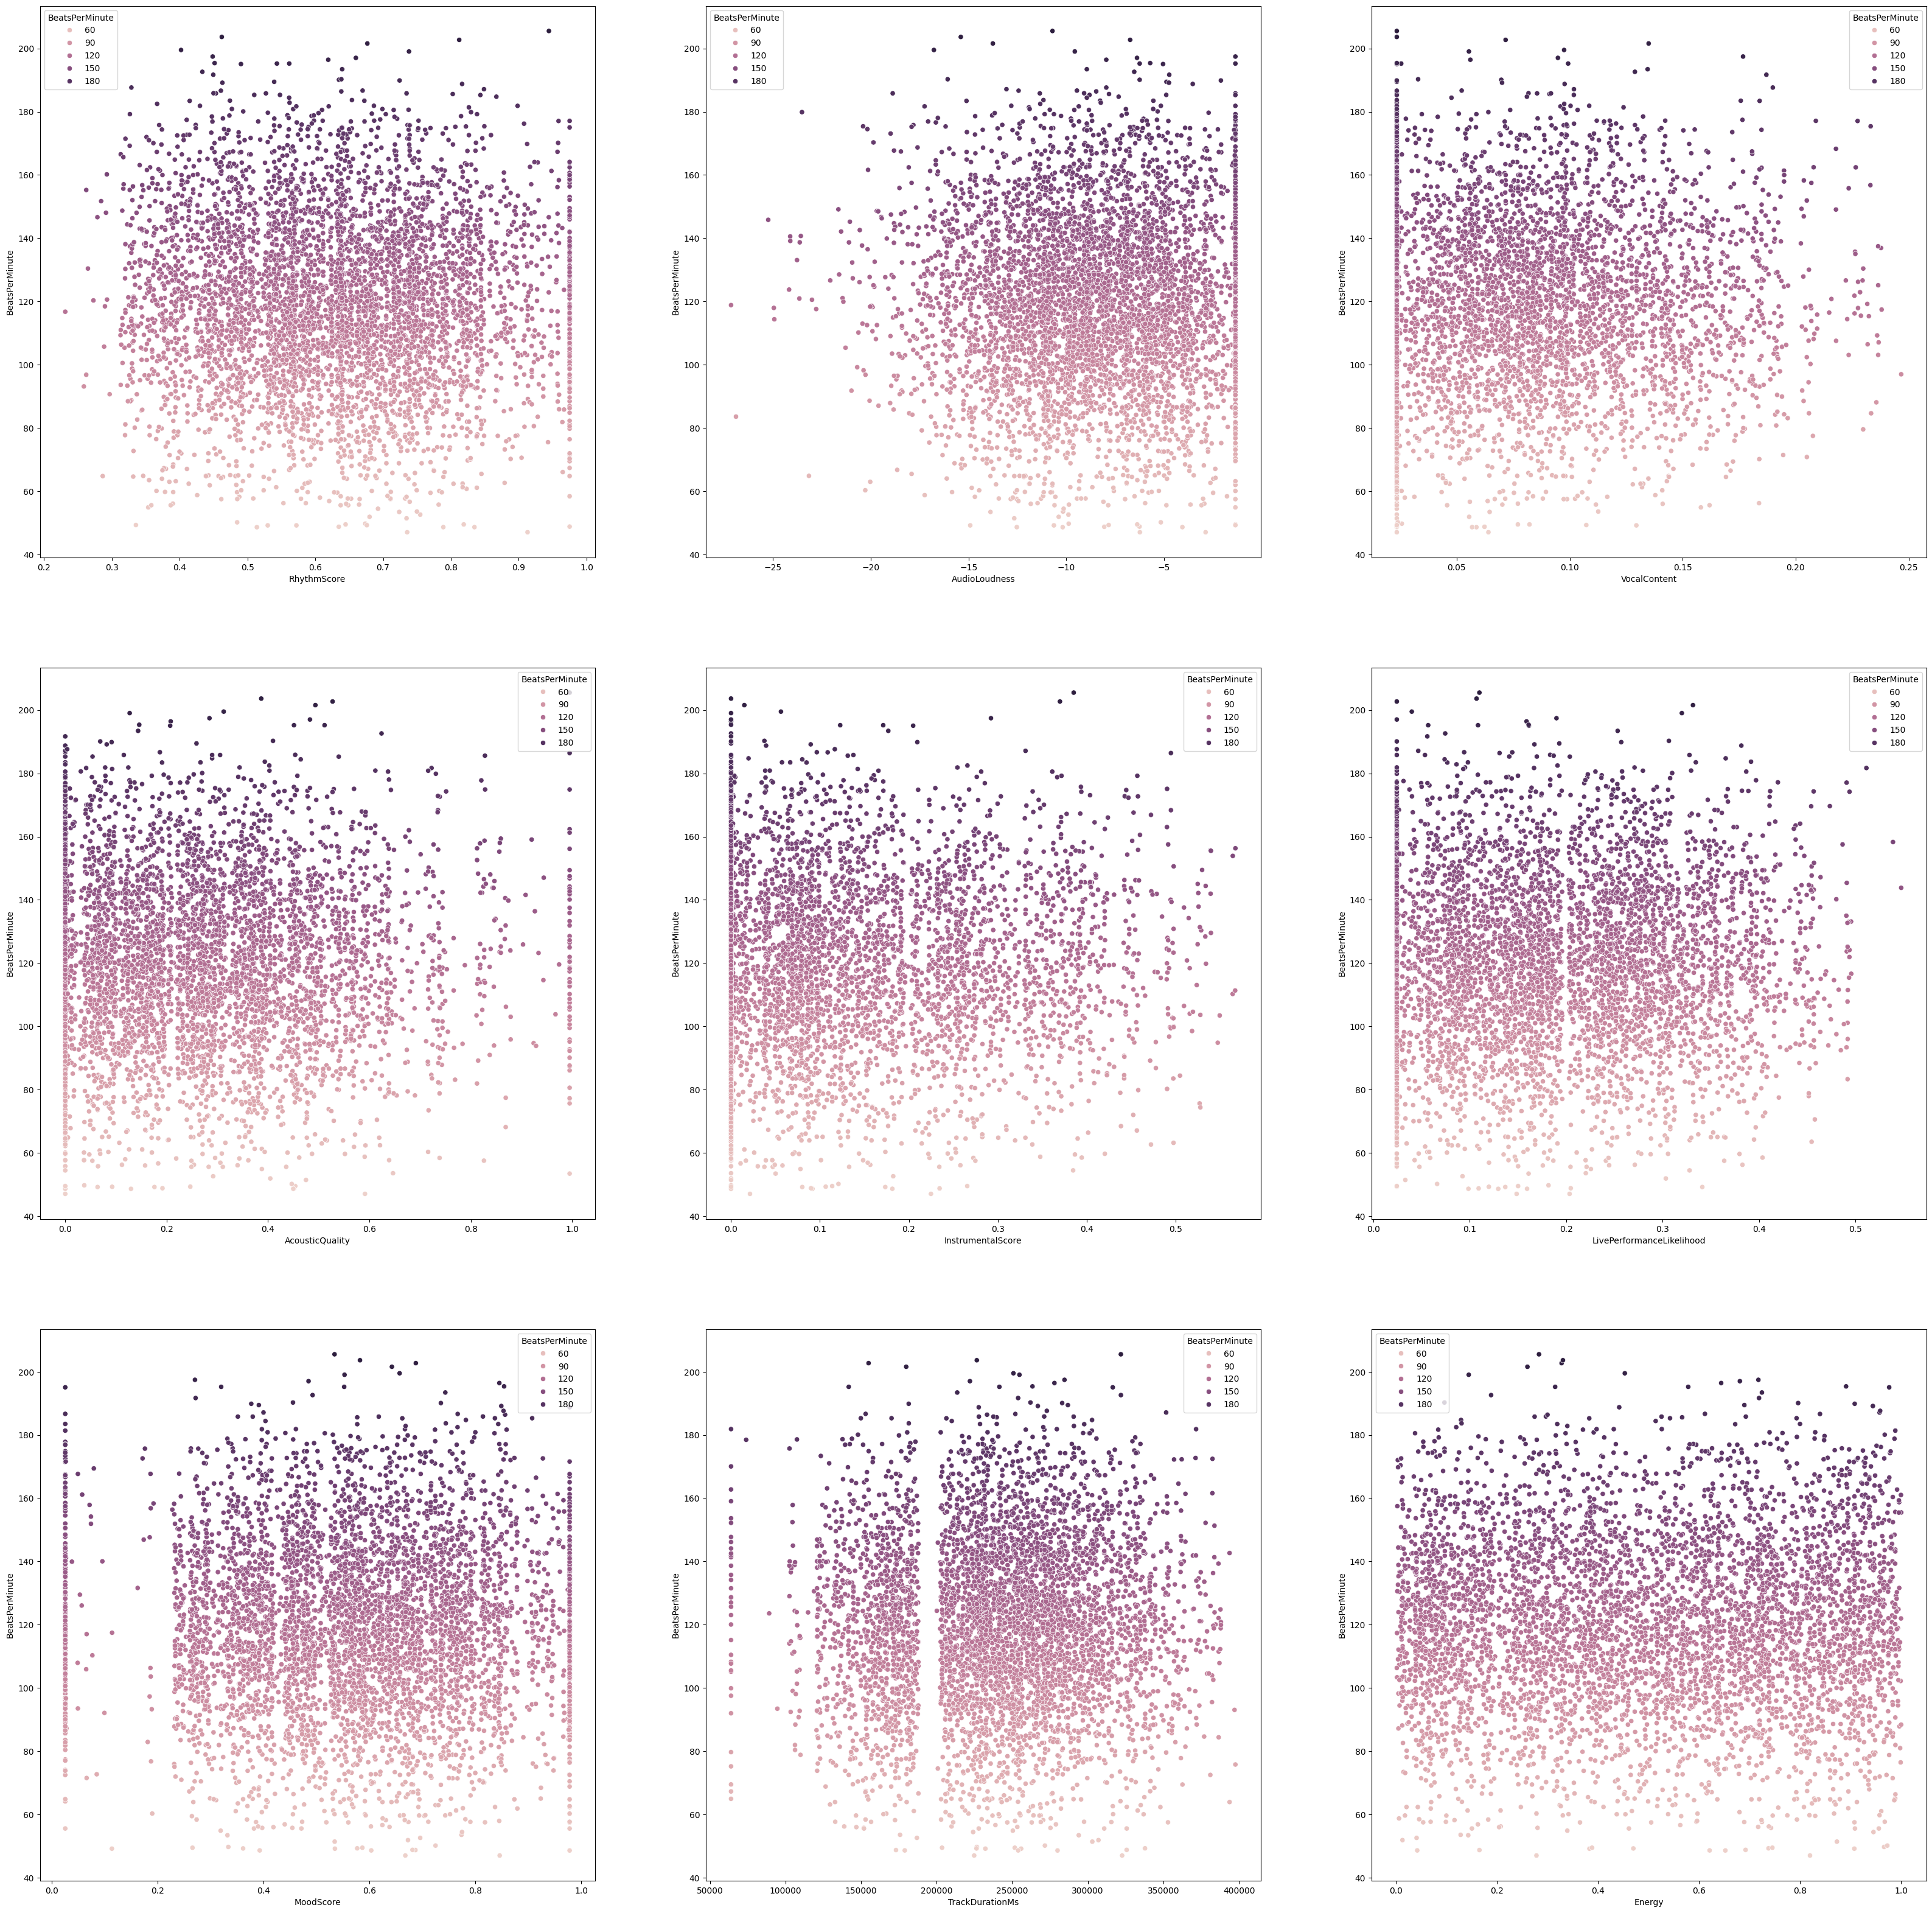

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(40, 40))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='BeatsPerMinute', data = sampled_train, ax=subplot, hue = 'BeatsPerMinute')

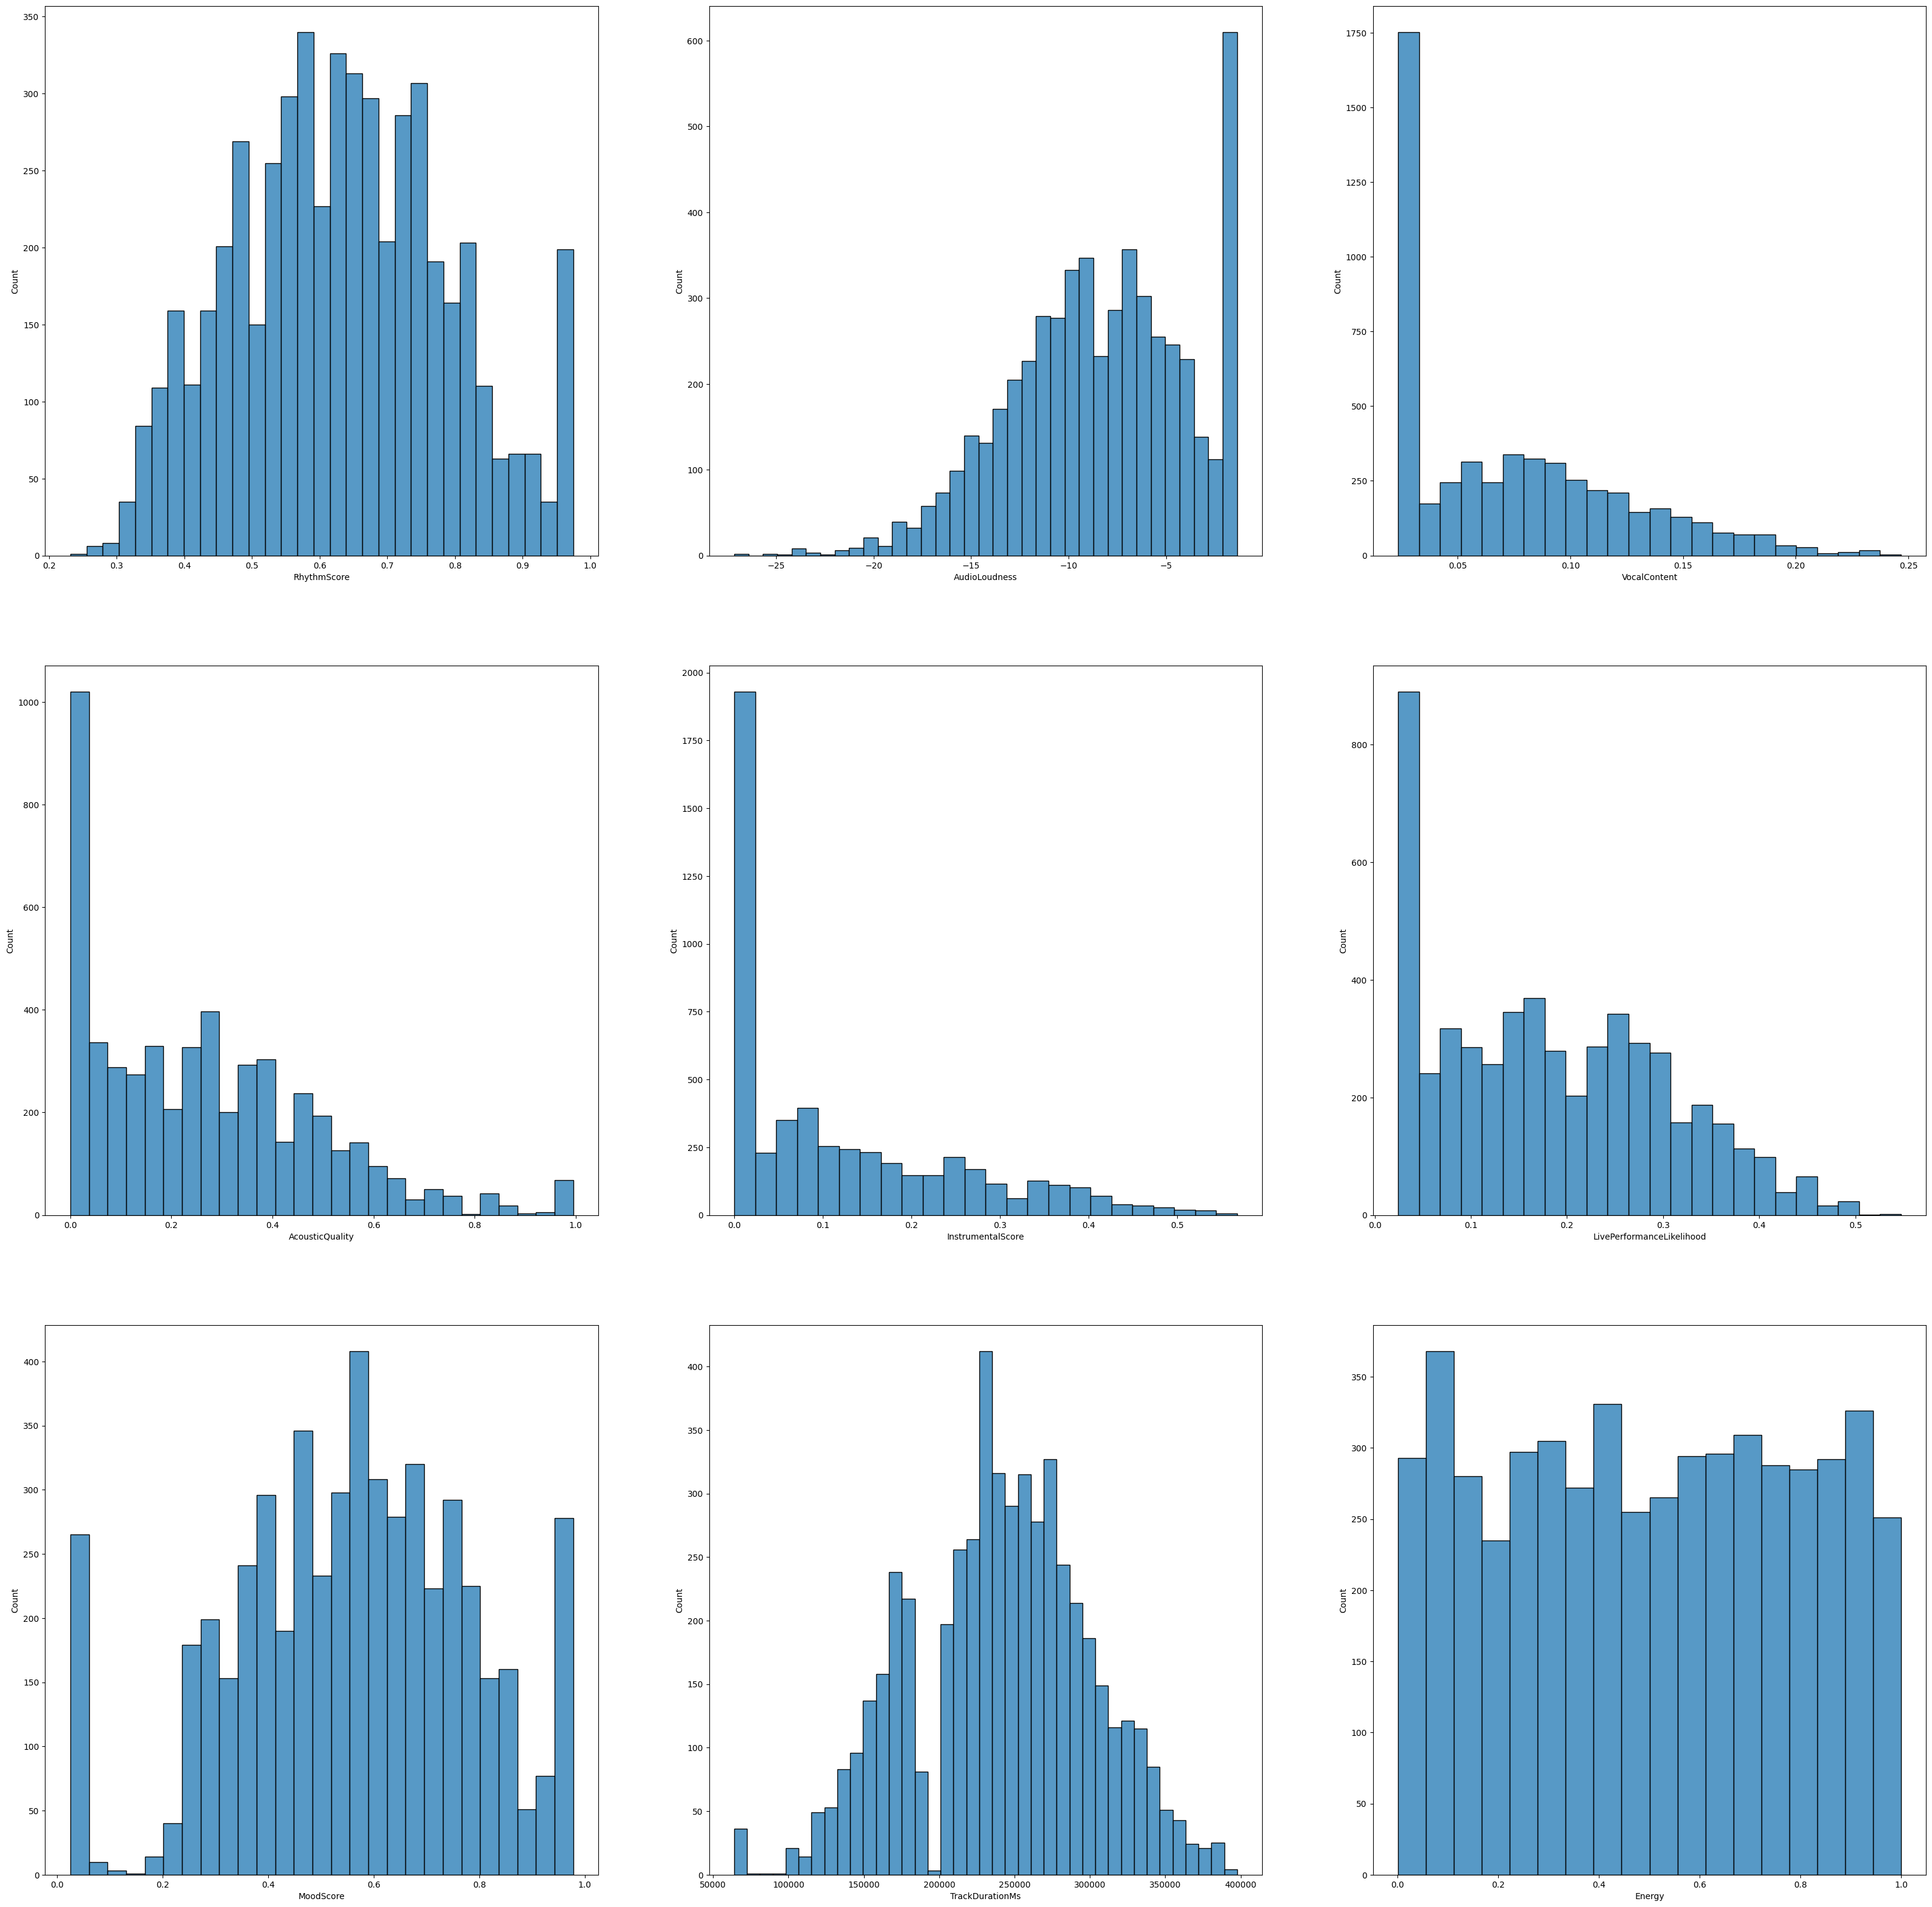

In [9]:
fig, ax = plt.subplots(3,3, figsize=(40,40))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.histplot(x=var, data=sampled_train, ax=subplot)

A lot of features have zero-inflated distribution

In [10]:
def extended_describe(df):
    desc = df.describe().T
    desc["median"] = df.median()
    desc["~zeros_count"] = ((df < 0.05) & (df > 0)).sum().values
    desc["~zeros_percent"] = (((df < 0.05) & (df > 0)).sum() / len(df) * 100).values
    desc["mode"] = [df[col].mode().iloc[0] if not df[col].mode().empty else np.nan for col in df.columns]
    desc.drop(columns=["25%", "50%", "75%"], inplace=True)
    return desc

extended_describe(train_df)

count           mean           std  \
RhythmScore                524164.0       0.632843      0.156899   
AudioLoudness              524164.0      -8.379014      4.616221   
VocalContent               524164.0       0.074443      0.049939   
AcousticQuality            524164.0       0.262913      0.223120   
InstrumentalScore          524164.0       0.117690      0.131845   
LivePerformanceLikelihood  524164.0       0.178398      0.118186   
MoodScore                  524164.0       0.555843      0.225480   
TrackDurationMs            524164.0  241903.692949  59326.601501   
Energy                     524164.0       0.500923      0.289952   
BeatsPerMinute             524164.0     119.034899     26.468077   

                                    min            max         median  \
RhythmScore                    0.076900       0.975000       0.634686   
AudioLoudness                -27.509725      -1.357000      -8.252499   
VocalContent                   0.023500       0.256401       0.066425   
AcousticQuality                0.000005       0.995000       0.242502   
InstrumentalScore              0.000001       0.869258       0.074247   
LivePerformanceLikelihood      0.024300       0.599924       0.166327   
MoodScore                      0.025600       0.978000       0.564817   
TrackDurationMs            63973.000000  464723.228100  243684.058150   
Energy                         0.000067       1.000000       0.511800   
BeatsPerMinute                46.718000     206.037000     118.747660   

                           ~zeros_count  ~zeros_percent          mode  
RhythmScore                           0        0.000000      0.975000  
AudioLoudness                         0        0.000000     -1.357000  
VocalContent                     210940       40.243130      0.023500  
AcousticQuality                  112152       21.396357      0.000005  
InstrumentalScore                224965       42.918819      0.000001  
LivePerformanceLikelihood         99115       18.909158      0.024300  
MoodScore                         25073        4.783427      0.025600  
TrackDurationMs                       0        0.000000  63973.000000  
Energy                            26116        4.982410      0.515467  
BeatsPerMinute                        0        0.000000    103.801320

### Correlation analysis

### Spearman corr triangle

<Axes: >

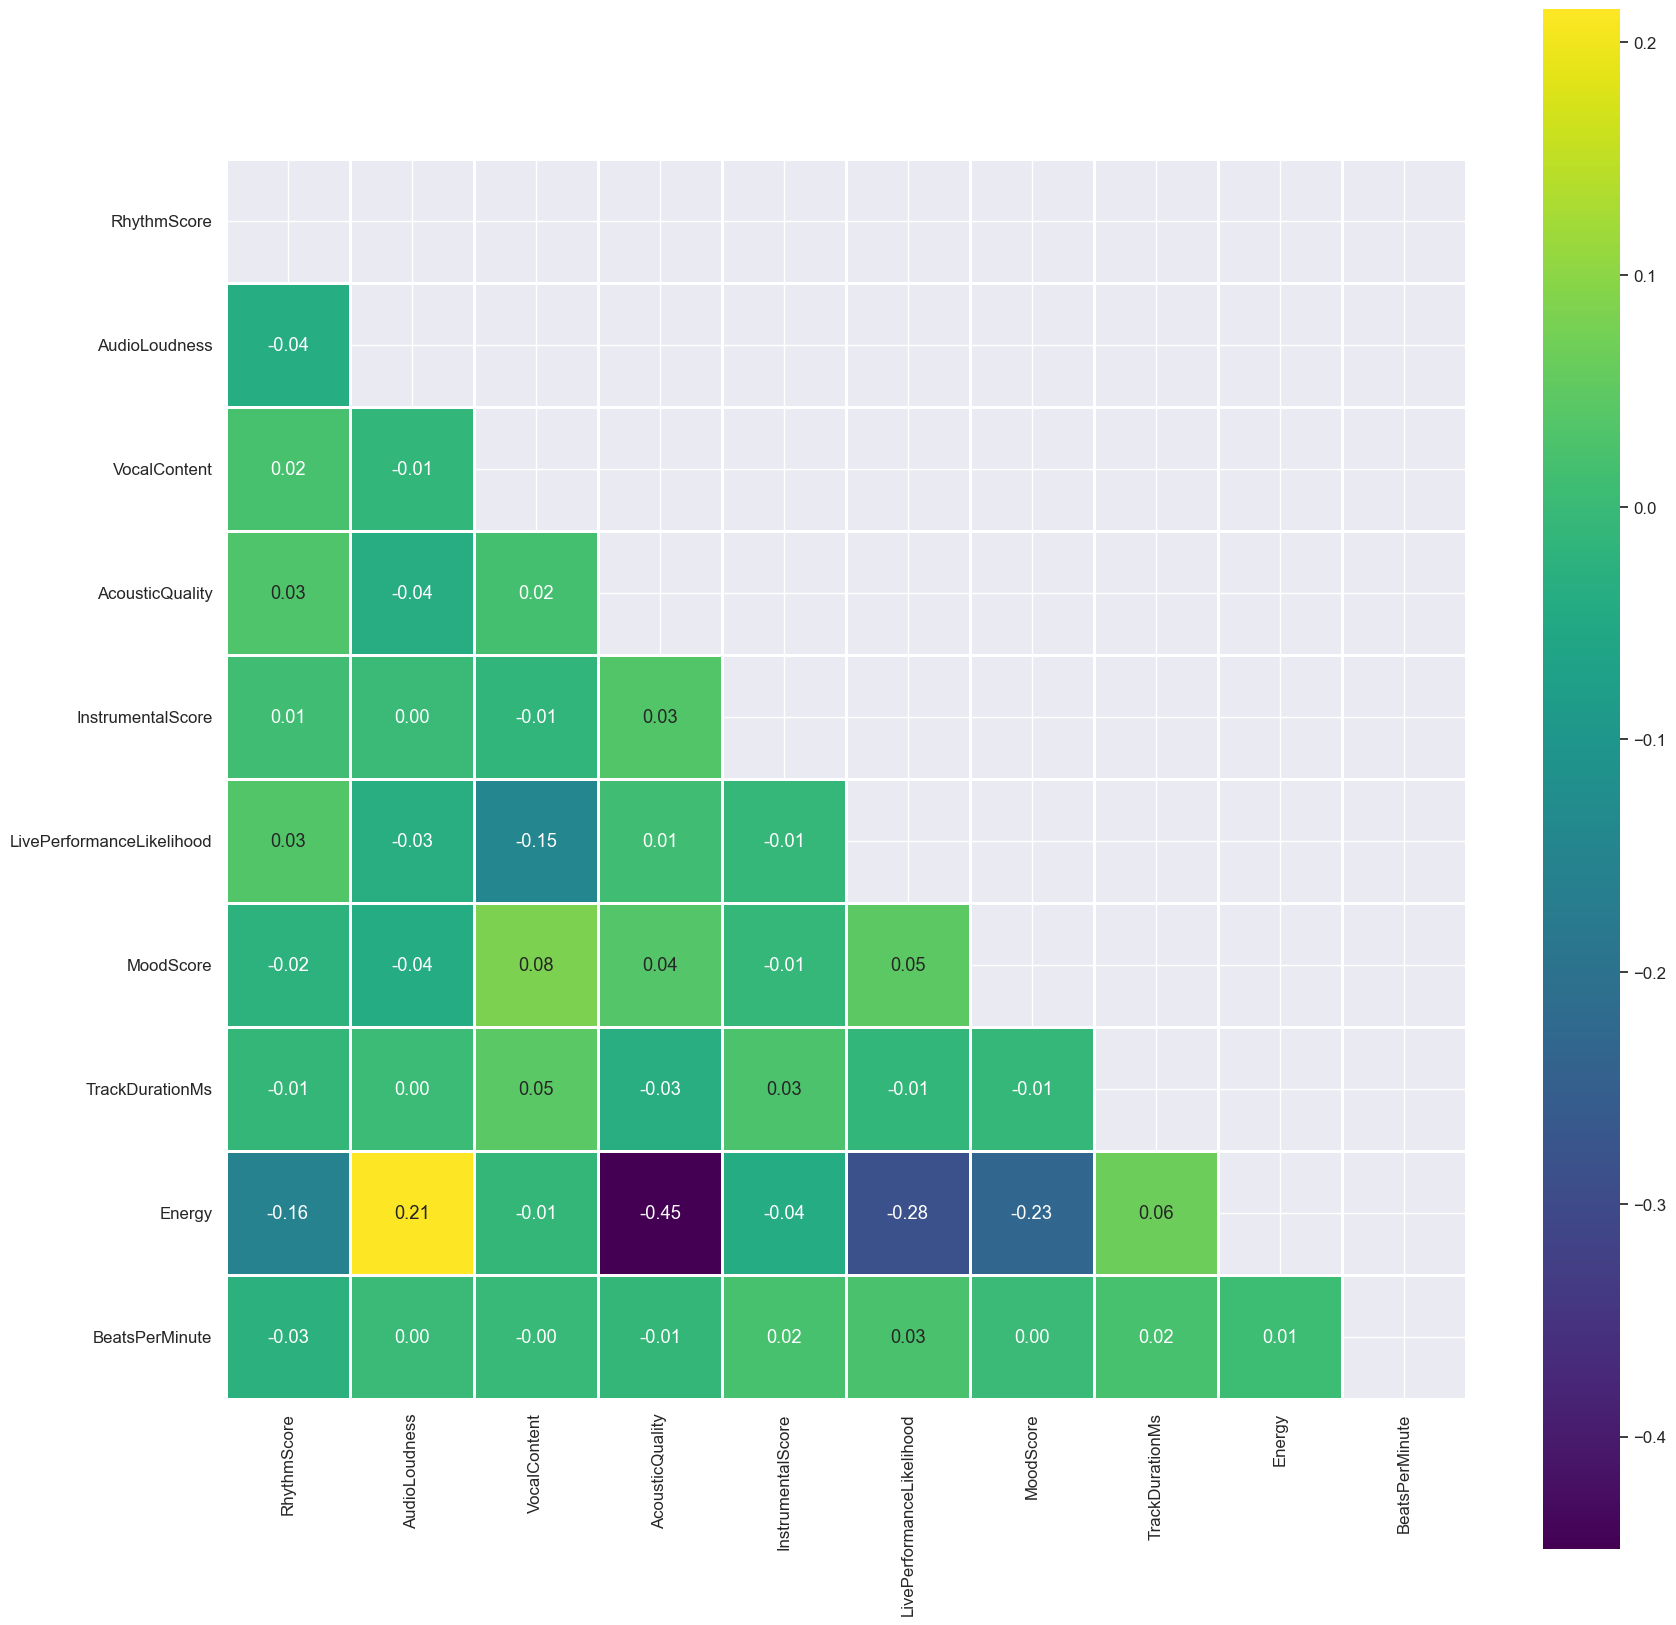

In [11]:
# Display correlations between numerical features and target on heatmap.
sns.set(font_scale=1.1)
corr_train = sampled_train.corr(method="spearman")
mask = np.triu(corr_train.corr(method="spearman"))
plt.figure(figsize=(20,20))
sns.heatmap(corr_train, annot=True, fmt='.2f', cmap='viridis', square=True, mask=mask, linewidths=1)

### Mutual information

In [12]:
# Mutual Information score
y_sampled = sampled_train.BeatsPerMinute
features_sampled = sampled_train[numerical_features]

mutual_info = mutual_info_regression(features_sampled, y_sampled, random_state=random_state)
mutual_info_s = pd.Series(mutual_info)
mutual_info_s.index = features_sampled.columns
mutual_info_s = pd.DataFrame(mutual_info_s.sort_values(ascending=False), columns = ['Num Feature'])
mutual_info_s.style.background_gradient("cool")

### Target distribution

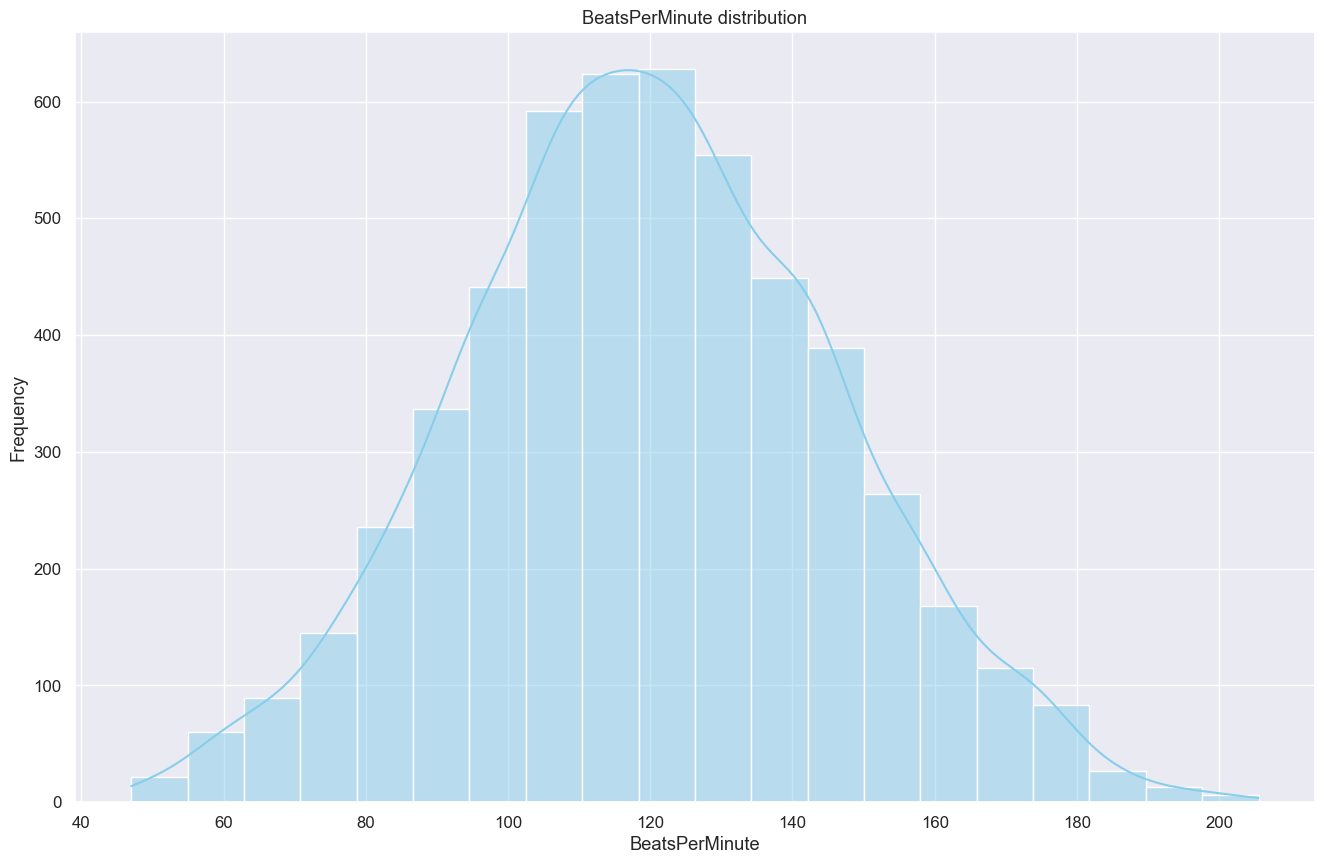

In [13]:
plt.figure(figsize=(16,10))
sns.histplot(x='BeatsPerMinute', data=sampled_train, bins=20, color='Skyblue', kde=True)
plt.title('BeatsPerMinute distribution')
plt.ylabel('Frequency')
plt.xlabel('BeatsPerMinute')
plt.show()

## Feature Engineering

### Custom feature engineering transformer

In [14]:
#Custom transformer

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, add_attributes=True):
        self.add_attributes = add_attributes
        self.new_feature_names = []
    def fit(self, X, y=None):
        #Placeholder
        return self
    
    def transform(self, X):
        # Placeholder
        return X
    
    def get_feature_names_out(self, input_features=None):
        # Output feature names
        if self.add_attributes:
            return self.new_feature_names
        else:
            return list(input_features) if input_features is not None else []
FeatureEngineer = FeatureEngineer()

### Preprocessing

In [15]:
numerical_transformer = StandardScaler()

## Cross validation

In [16]:
cross_valid = KFold(n_splits=10, random_state=random_state, shuffle=True)

### Custom cv function

In [17]:
def cv_score(model,
    data,
    cross_valid,
    label='BeatsPerMinute',
    early_stopping_rounds=50):
    
    if not hasattr(data, "copy") or not hasattr(data, "columns"):
        raise TypeError("data must be a pandas DataFrame")
    if label not in data.columns:
        raise KeyError(f"target column '{label}' not found")
        
    X = data.drop(columns=[label]).copy()
    y = data[label]
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.select_dtypes(include=[np.number]).copy()
    X = X.fillna(X.median(numeric_only=True))
    
    #Preparing variables for predictions
    val_predictions = np.zeros(len(X))
    val_true = np.zeros(len(y))
    val_scores, train_scores = [], []
    for fold, (train_idx, val_idx) in enumerate(cross_valid.split(X, y)):
        X_train, y_train = X.iloc[train_idx].reset_index(drop=True), y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx].reset_index(drop=True), y.iloc[val_idx]
        m = clone(model)
        
        if hasattr(m, "n_jobs"):
            m.set_params(n_jobs=1)
            
        # Early stopping logic
        fit_params = {}
        if early_stopping_rounds is not None:
            # XGBoost
            if isinstance(m, XGBRegressor):
                pass
            #         fit_params['early_stopping_rounds'] = early_stopping_rounds
            #         fit_params['eval_set'] = [(X_val, y_val)]
            #         fit_params['verbose'] = False
                # except TypeError:
                #     from xgboost.callback import EarlyStopping
                #     fit_params['callbacks'] = [EarlyStopping(rounds=early_stopping_rounds, save_best=True)]
                #     fit_params['eval_set'] = [(X_val, y_val)]
        
            # CatBoost
            elif isinstance(m, CatBoostRegressor):
                fit_params['early_stopping_rounds'] = early_stopping_rounds
                fit_params['eval_set'] = [(X_val, y_val)]
                fit_params['verbose'] = False
        
            # LightGBM
            elif isinstance(m, LGBMRegressor):
                pass
                # from lightgbm import early_stopping
                # fit_params['callbacks'] = [early_stopping(stopping_rounds=early_stopping_rounds)]
                # fit_params['eval_set'] = [(X_val, y_val)]
        if fit_params:    
            m.fit(X_train, y_train, **fit_params)
        else:
            m.fit(X_train, y_train)
            
        train_preds = m.predict(X_train)
        val_preds = m.predict(X_val)

        val_predictions[val_idx] = val_preds
        val_true[val_idx] = y_val.values

        # Metics(RMSE)
        train_score = np.sqrt(mean_squared_error(y_train, train_preds))
        val_score   = np.sqrt(mean_squared_error(y_val, val_preds))

        train_scores.append(train_score)
        val_scores.append(val_score)
        
        print(f"fold {fold + 1} rmse={val_score:.5f}", flush=True)
        
    # Result  is mean of RMSE on validation and training folds
    print(f"Val RMSE: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | "
          f"Train RMSE: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f}")

    return val_scores, val_predictions, val_true

In [18]:
val_scores_df, val_predictions_df, val_true_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

## Modeling

### Linear regresion RIDGE

In [50]:
ridge_optuna_params = {'max_iter': 969,
                       'alpha': 996.2276353844511,
                       'tol': 4.41828902390748e-05}
ridge_tuned = Ridge(**ridge_optuna_params, random_state=random_state)
ridge_pipe = Pipeline(steps=[
    #('FeatureEngineer', FeatureEngineer),
    ('numerical_transformer', numerical_transformer),
    ('ridge', ridge_tuned)
])

ridge_pipe

Pipeline(steps=[('numerical_transformer', StandardScaler()),
                ('ridge',
                 Ridge(alpha=996.2276353844511, max_iter=969, random_state=42,
                       tol=4.41828902390748e-05))])

In [51]:
%%time
val_scores_df['RIDGE'], val_predictions_df['RIDGE'], val_true_df['RIDGE'] = cv_score(ridge_pipe, data = pipe_train, cross_valid=cross_valid)
pipe_train.head()

fold 1 rmse=26.44014
fold 2 rmse=26.44704
fold 3 rmse=26.52103
fold 4 rmse=26.46181
fold 5 rmse=26.52940
fold 6 rmse=26.52831
fold 7 rmse=26.45221
fold 8 rmse=26.44975
fold 9 rmse=26.40896
fold 10 rmse=26.42249
Val RMSE: 26.46611 ± 0.04192 | Train RMSE: 26.46572 ± 0.00466
CPU times: total: 875 ms
Wall time: 2.03 s


RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
id                                                              
0      0.603610      -7.636942      0.023500         0.000005   
1      0.639451     -16.267598      0.071520         0.444929   
2      0.514538     -15.953575      0.110715         0.173699   
3      0.734463      -1.357000      0.052965         0.001651   
4      0.532968     -13.056437      0.023500         0.068687   

    InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
id                                                                             
0            0.000001                   0.051385   0.409866      290715.6450   
1            0.349414                   0.170522   0.651010      164519.5174   
2            0.453814                   0.029576   0.423865      174495.5667   
3            0.159717                   0.086366   0.278745      225567.4651   
4            0.000001                   0.331345   0.477769      213960.6789   

      Energy  BeatsPerMinute  
id                            
0   0.826267       147.53020  
1   0.145400       136.15963  
2   0.624667        55.31989  
3   0.487467       147.91212  
4   0.947333        89.58511

In [53]:
val_predictions_df['RIDGE'].min()

np.float64(117.44533928936778)

### XGB regressor

In [21]:
# Find best params with Optuna
# def objective(trial, data, cv):
#     params = {
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#         "alpha": trial.suggest_float("alpha", 0.0, 1.0),
#         "gamma": trial.suggest_float("gamma", 0.0, 5.0),
#     }

#     model = XGBRegressor(random_state=42, **params)
#     print(type(model))
#     scores = cv_score(model, data, cross_valid=cv)
#     val_score = scores[0]
#     return np.mean(val_score)

# study = optuna.create_study(direction="minimize")
# def save_best_params(study, trial):
#     with open("xgboost_bestparams.json", "w") as f:
#         json.dump(study.best_params, f, indent=4)
# study.optimize(lambda trial: objective(trial, data = pipe_train, cv = cross_valid), n_trials=20, callbacks=[save_best_params])

# print("Best RMSE:", study.best_trial.value)
# print("Best params:", study.best_trial.params)

# XGB regressor with optuna best params
with open("xgboost_bestparams.json", "r") as f:
    xgb_optuna_params = json.load(f)

xgb_tuned = XGBRegressor(
    **xgb_optuna_params,
    random_state=random_state
 )

xgb_pipe = Pipeline(steps=[
    ('FeatureEngineer', FeatureEngineer),
    ('xgb_tuned', xgb_tuned)
])

xgb_pipe

Pipeline(steps=[('FeatureEngineer', FeatureEngineer()),
                ('xgb_tuned',
                 XGBRegressor(alpha=0.1839069500608018, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.6176815072070047, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=1.3883574059853983, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.01787766885258865, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None, ...))])

In [22]:
val_scores_df['XGBOOST'], val_predictions_df['XGBOOST'], val_true_df['XGBOOST'] = cv_score(xgb_pipe, data = pipe_train,cross_valid=cross_valid)

fold 1 rmse=26.43576
fold 2 rmse=26.44369
fold 3 rmse=26.51585
fold 4 rmse=26.45796
fold 5 rmse=26.52492
fold 6 rmse=26.52595
fold 7 rmse=26.44790
fold 8 rmse=26.44420
fold 9 rmse=26.40356
fold 10 rmse=26.41586
Val RMSE: 26.46156 ± 0.04248 | Train RMSE: 26.44313 ± 0.00464


### Lightgbm regressor

In [23]:
lgbm_optuna_params = {
    'n_estimators': 934,
    'max_depth': 16,
    'learning_rate': 0.003717017250694586,
    'min_data_in_leaf': 56,
    'subsample': 0.939684807121632,
    'max_bin': 420,
    'feature_fraction': 0.8416988483664828
}

lgbm_tuned = LGBMRegressor(
    **lgbm_optuna_params,
    random_state=random_state,
    verbose=-1
)

lgbm_pipe = Pipeline(steps=[
    ('FeatureEngineer', FeatureEngineer),
    ('lgbm_tuned', lgbm_tuned)
])

lgbm_pipe

Pipeline(steps=[('FeatureEngineer', FeatureEngineer()),
                ('lgbm_tuned',
                 LGBMRegressor(feature_fraction=0.8416988483664828,
                               learning_rate=0.003717017250694586, max_bin=420,
                               max_depth=16, min_data_in_leaf=56,
                               n_estimators=934, random_state=42,
                               subsample=0.939684807121632, verbose=-1))])

In [37]:
val_scores_df['GBM'], val_predictions_df['GBM'], val_true_df['GBM'] = cv_score(lgbm_pipe, data = pipe_train, cross_valid=cross_valid)

fold 1 rmse=26.43416
fold 2 rmse=26.44156
fold 3 rmse=26.51076
fold 4 rmse=26.45500
fold 5 rmse=26.51950
fold 6 rmse=26.52560
fold 7 rmse=26.44426
fold 8 rmse=26.44122
fold 9 rmse=26.40171
fold 10 rmse=26.41444
Val RMSE: 26.45882 ± 0.04185 | Train RMSE: 26.41577 ± 0.00474


### Catboost regressor

In [25]:
catb_optuna_params = {
    'iterations': 100,
    'colsample_bylevel': 0.884050283064001,
    'learning_rate': 0.03501796397486782,
    'random_strength': 0.01644595544178421,
    'border_count': 300,
    'depth': 6,
    'l2_leaf_reg': 7,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8615585051787144
}

catb_tuned = CatBoostRegressor(
    **catb_optuna_params,
    random_state=random_state,
    logging_level='Silent'
)

catb_pipe = Pipeline(steps=[
    ('FeatureEngineer', FeatureEngineer),
    ('catb_tuned', catb_tuned)
])

catb_pipe

Pipeline(steps=[('FeatureEngineer', FeatureEngineer()),
                ('catb_tuned',
                 <catboost.core.CatBoostRegressor object at 0x000001B578C38250>)])

In [26]:
val_scores_df['CB'], val_predictions_df['CB'], val_true_df['CB'] = cv_score(catb_pipe, data = pipe_train, cross_valid=cross_valid)

fold 1 rmse=26.43402
fold 2 rmse=26.44309
fold 3 rmse=26.51217
fold 4 rmse=26.45551
fold 5 rmse=26.52186
fold 6 rmse=26.52269
fold 7 rmse=26.44469
fold 8 rmse=26.44260
fold 9 rmse=26.40167
fold 10 rmse=26.41417
Val RMSE: 26.45925 ± 0.04182 | Train RMSE: 26.44116 ± 0.00478


## Performance Summary

In [27]:
transposed_df = val_scores_df.transpose()
transposed_df.columns = ['fold-1','fold2','fold3','fold4','fold5', 'fold-6','fold7','fold8','fold9','fold10' ]
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=True).style.background_gradient('Dark2_r')

### Divercity check

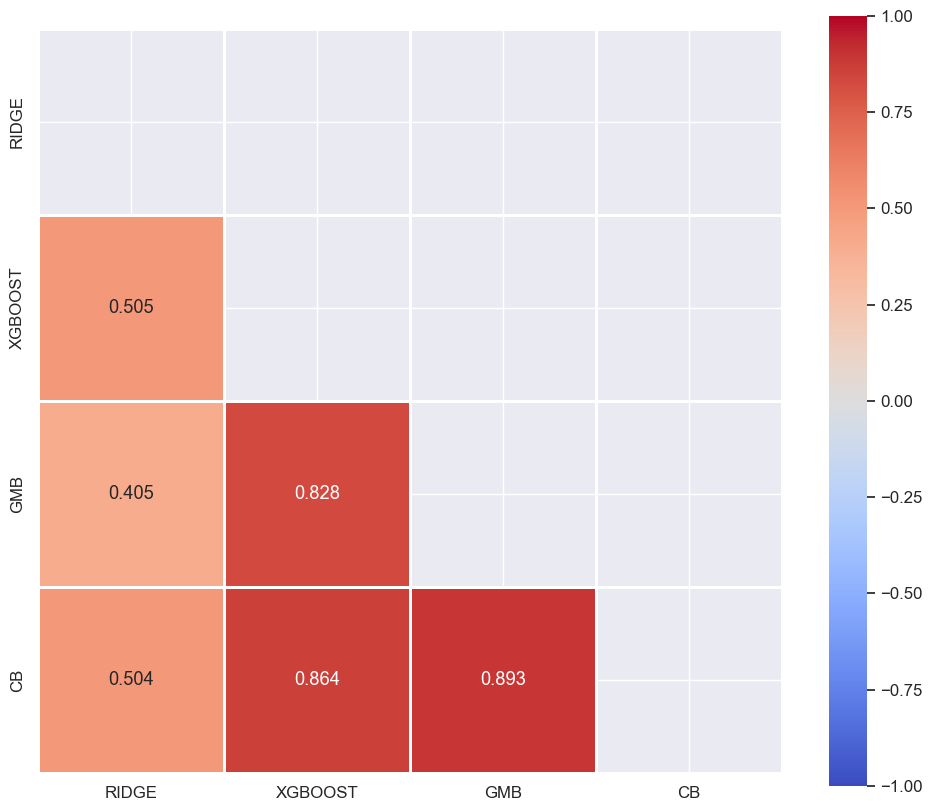

In [28]:
sns.set(font_scale=1.1)
correlation_train = val_predictions_df.corr()
mask = np.triu(np.ones_like(correlation_train, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            vmin=-1, vmax=1, center=0,
            square=True,
            mask=mask,
            linewidths=1,
            cbar=True)
plt.show()

## Model stacking

In [29]:
from sklearn.pipeline import make_pipeline
from optuna.samplers import TPESampler

# Ridge regressor as meta regressor. It uses oof_predictions_df.
def objective(trial):
    max_iter = trial.suggest_int("max_iter", 100, 4000)
    alpha = trial.suggest_float("alpha", 1e-4, 1000, log=True)
    tol = trial.suggest_float("tol", 1e-6, 1e-3, log=True)

    ensemble_regressor = Ridge(max_iter=max_iter, alpha=alpha, tol=tol)
    ensemble_pipeline = make_pipeline(StandardScaler(), ensemble_regressor)

    ss = cross_valid
    
    score = cross_val_score(ensemble_pipeline, val_predictions_df, pipe_train.BeatsPerMinute, scoring= "neg_root_mean_squared_error",  cv=ss)
    return score.mean()

sampler = TPESampler(seed=random_state)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)


[I 2025-10-09 13:44:14,792] A new study created in memory with name: no-name-9241d407-b94a-49e0-9775-d57f0a630147
[I 2025-10-09 13:44:15,561] Trial 0 finished with value: -26.45863162321075 and parameters: {'max_iter': 1561, 'alpha': 451.85609510240965, 'tol': 0.000157029708840554}. Best is trial 0 with value: -26.45863162321075.
[I 2025-10-09 13:44:16,331] Trial 1 finished with value: -26.458632428972418 and parameters: {'max_iter': 2435, 'alpha': 0.0012363188277052211, 'tol': 2.9375384576328313e-06}. Best is trial 0 with value: -26.45863162321075.
[I 2025-10-09 13:44:17,107] Trial 2 finished with value: -26.45863221926995 and parameters: {'max_iter': 326, 'alpha': 115.67327199145953, 'tol': 6.358358856676247e-05}. Best is trial 0 with value: -26.45863162321075.
[I 2025-10-09 13:44:17,852] Trial 3 finished with value: -26.45863242897442 and parameters: {'max_iter': 2862, 'alpha': 0.000139345022513376, 'tol': 0.0008123245085588687}. Best is trial 0 with value: -26.45863162321075.
[I 20

In [30]:
ensemble_params = {
    'max_iter': 969,
    'alpha': 996.2276353844511,
    'tol': 4.41828902390748e-05
}

ridge_ensemble = Ridge(
    **ensemble_params,
    random_state=random_state
)

ensemble_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ridge_ensemble', ridge_ensemble)
])

In [54]:
min_features_to_select = 1

pipeline = Pipeline([
    ('rfecv', RFECV(
        estimator=ensemble_pipe,                    
        step=1,
        cv = cross_valid,
        scoring="neg_root_mean_squared_error",
        min_features_to_select=min_features_to_select,
        n_jobs=1,
        importance_getter=lambda est: est.named_steps['ridge_ensemble'].coef_
    ))
])

# Fit
pipeline.fit(val_predictions_df, pipe_train.BeatsPerMinute)

# Results
rfecv_step = pipeline.named_steps['rfecv']
mean_scores = rfecv_step.cv_results_["mean_test_score"]  # negative RMSE
best_idx = np.argmax(mean_scores)
best_rmse = -mean_scores[best_idx]

support = rfecv_step.support_
selected_models = np.array(val_predictions_df.columns)[support]

print("Best CV RMSE:", best_rmse)
print('Number of evaluated models:', val_predictions_df.shape[1])
print('Number of selected models:', support.sum())
print('Selected Models for Ensemble:', selected_models)

Best CV RMSE: 26.45855534095681
Number of evaluated models: 5
Number of selected models: 2
Selected Models for Ensemble: ['GMB' 'CB']


In [35]:
val_predictions_df.head()

RIDGE     XGBOOST         GMB          CB
0  118.804743  118.826080  118.936596  118.922008
1  119.043489  118.921181  118.792235  118.808890
2  118.862778  119.068031  119.190528  118.851570
3  118.698740  118.739296  118.478520  118.628731
4  118.810416  118.976753  119.078672  118.941388

## Final evaluation and prediction

In [39]:
X_train = pipe_train.drop(columns=['BeatsPerMinute'])
X_train = X_train.replace([np.inf, -np.inf], np.nan).select_dtypes(include=[np.number])
X_train = X_train.fillna(X_train.median(numeric_only=True))
y_train = pipe_train['BeatsPerMinute'].astype(float).values

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
catb_tuned.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
lgbm_tuned.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(100)])
ridge_tuned.fit(X_train, y_train)

X_test = pipe_test.drop(columns=['BeatsPerMinute'], errors='ignore')
X_test = X_test.replace([np.inf, -np.inf], np.nan).select_dtypes(include=[np.number])
X_test = X_test.reindex(columns=X_train.columns)
X_test = X_test.fillna(X_train.median(numeric_only=True))

cols = ['RIDGE','CB','GBM']
X_meta = val_predictions_df[cols].astype(float)
y_meta = pipe_train.loc[val_predictions_df.index, 'BeatsPerMinute'].astype(float)

meta = make_pipeline(SimpleImputer(strategy="median"),
                     StandardScaler(),
                     Ridge(**study.best_params))
meta.fit(X_meta, y_meta)

pred_cb_test = catb_tuned.predict(X_test)
pred_gbm_test = lgbm_tuned.predict(X_test)
pred_ridge_test = ridge_tuned.predict(X_test)

P_test = pd.DataFrame({'CB': pred_cb_test, 'GBM': pred_gbm_test, 'RIDGE': pred_ridge_test}, index=X_test.index).astype(float)
pred_final = meta.predict(P_test[cols])
out = pd.DataFrame({'id': X_test.index, 'prediction': pred_final})
out.to_csv('attempt.csv', index=False)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's l2: 701.019
